In [269]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

In [270]:
Nx, Ny, Nz = 64, 1, 64
et = 1.0

def load(Nx,Ny,Nz,et):
    base_fn = 'output_swe_vortex'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    
    return tc, tags
tc, tags = load(Nx,Ny,Nz,et)

## Import and initialise data for analysis

In [271]:
import random

random.seed(444)

N = 10
sfx = 'noda_p0.1'
sfx = 'wdawloc_1.0_rhou_rhow_p0.5_debug'
# sfx = tc.cb_suffix(1,0, '%s' %(sfx))
print(sfx)

fn_pickle = tc.get_filename(N,sfx,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

# ensemble coriolis = 0 but truth = 10.0, we use true coriolis in the DSI calculation
ud.coriolis_strength[0] = 10.0
ud.coriolis_strength[2] = 10.0

times = [0.0]
tag = 'ic'

# times = [0.49,0.5]
times = np.arange(0.0,1.01,0.01)#[::20]
# times = np.arange(0.0,0.11,0.01)[::5]
tag = tags[9]

g = 9.81

attributes = ['rho','rhou','rhow','vorty','rhoY','p2_nodes']

attr_labels = pt.labels()

class oo(object): pass
ens_time_series = np.empty((len(times),N+1),dtype='object')

print(ens_time_series.shape)
    
# fill ens_time_series with all time and attributes output.
for aa,attribute in enumerate(attributes):
    ens = tc.get_ensemble(times, N, attribute, sfx, tag=tag, inner=True)
    for tt,ens_at_time in enumerate(ens):
        mean = np.mean(ens_at_time,axis=0)[:,0,:]
        mean = mean.T
        for nn,mem in enumerate(ens_at_time):
            if aa == 0:
                ens_time_series[tt,nn] = oo()
            arr = mem[:,0,:].T
            setattr(ens_time_series[tt,nn],attribute,arr)
        if aa == 0:
            ens_time_series[tt,nn+1] = oo()
        setattr(ens_time_series[tt,nn+1],attribute,mean)

# calculate DSI-SW for each time and each ensemble member.
for tt,ens_at_time in enumerate(ens_time_series):
    for nn,mem in enumerate(ens_at_time):
#         print(tt,nn)
        dsi_sw = dsi.get_DSI_SW(mem, g, ud, elem)
        setattr(mem,'dsi_sw',dsi_sw)

wdawloc_1.0_rhou_rhow_p0.5_debug
(101, 11)


## Get and plot DSI-SW

In [272]:
plot = False

dsi_sw_arr = np.empty((ens_time_series.shape[0],N+1,2), dtype='object')

for tt,ens_at_time in enumerate(ens_time_series):
    for nn,mem in enumerate(ens_at_time):
        dsi_sw_arr[tt,nn] = [mem.dsi_sw, 'dsi_sw for mem %i at time-step %i' %(nn,tt)]

if plot == True:
    for tt,time in enumerate(times):
        fs = (22,16)
        pl = pt.plotter(dsi_sw_arr[tt],ncols=4,figsize=fs,sharey=False)

        x_axs = [-0.5,0.0,0.5]
        y_axs = [-0.5,0.0,0.5]
        x_loc = np.linspace(0,Nx-1,3)
        y_loc = np.linspace(0,Nz-1,3)
        x_label = r'x [km]'
        y_label = r'y [km]'
        st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vortcity in the (x-z) plane.' %(Nx,Nz)
        st = '(%ix%i), %s' %(Nx,Nz, sfx)

        pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
        _ = pl.plot(aspect='equal',method='contour',suptitle=st)

## Get and plot ensemble mean quantities for given time outputs

In [273]:
plot = False

mean_arrs = np.empty((ens_time_series.shape[0],len(attributes)+1,2), dtype='object')

# attributes_plus_mean = attributes + ['mean']
# print(attributes_plus_mean)

for tt,ens_at_time in enumerate(ens_time_series):
    for aa,attribute in enumerate(attributes):
        mean_arrs[tt,aa] = [getattr(ens_at_time[-1],attribute),'%s mean' %attribute]
    mean_arrs[tt,aa+1] = [getattr(ens_at_time[-1],'dsi_sw'),'%s mean' %'dsi_sw']
        
#     for nn,mem in enumerate(ens_at_time):
#         dsi_sw_arr[tt,nn] = [mem.dsi_sw, 'dsi_sw for mem %i at time-step %i' %(nn,tt)]

if plot == True:
    for tt,time in enumerate(times):
        fs = (26,12)
        pl = pt.plotter(mean_arrs[tt],ncols=4,figsize=fs,sharey=False)

        x_axs = [-0.5,0.0,0.5]
        y_axs = [-0.5,0.0,0.5]
        x_loc = np.linspace(0,Nx-1,3)
        y_loc = np.linspace(0,Nz-1,3)
        x_label = r'x [km]'
        y_label = r'y [km]'
        st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vortcity in the (x-z) plane.' %(Nx,Nz)
        st = '(%ix%i), %s' %(Nx,Nz, sfx)

        pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
        _ = pl.plot(aspect='equal',method='contour',suptitle=st)

## Prepare animation for the ensemble mean quantities

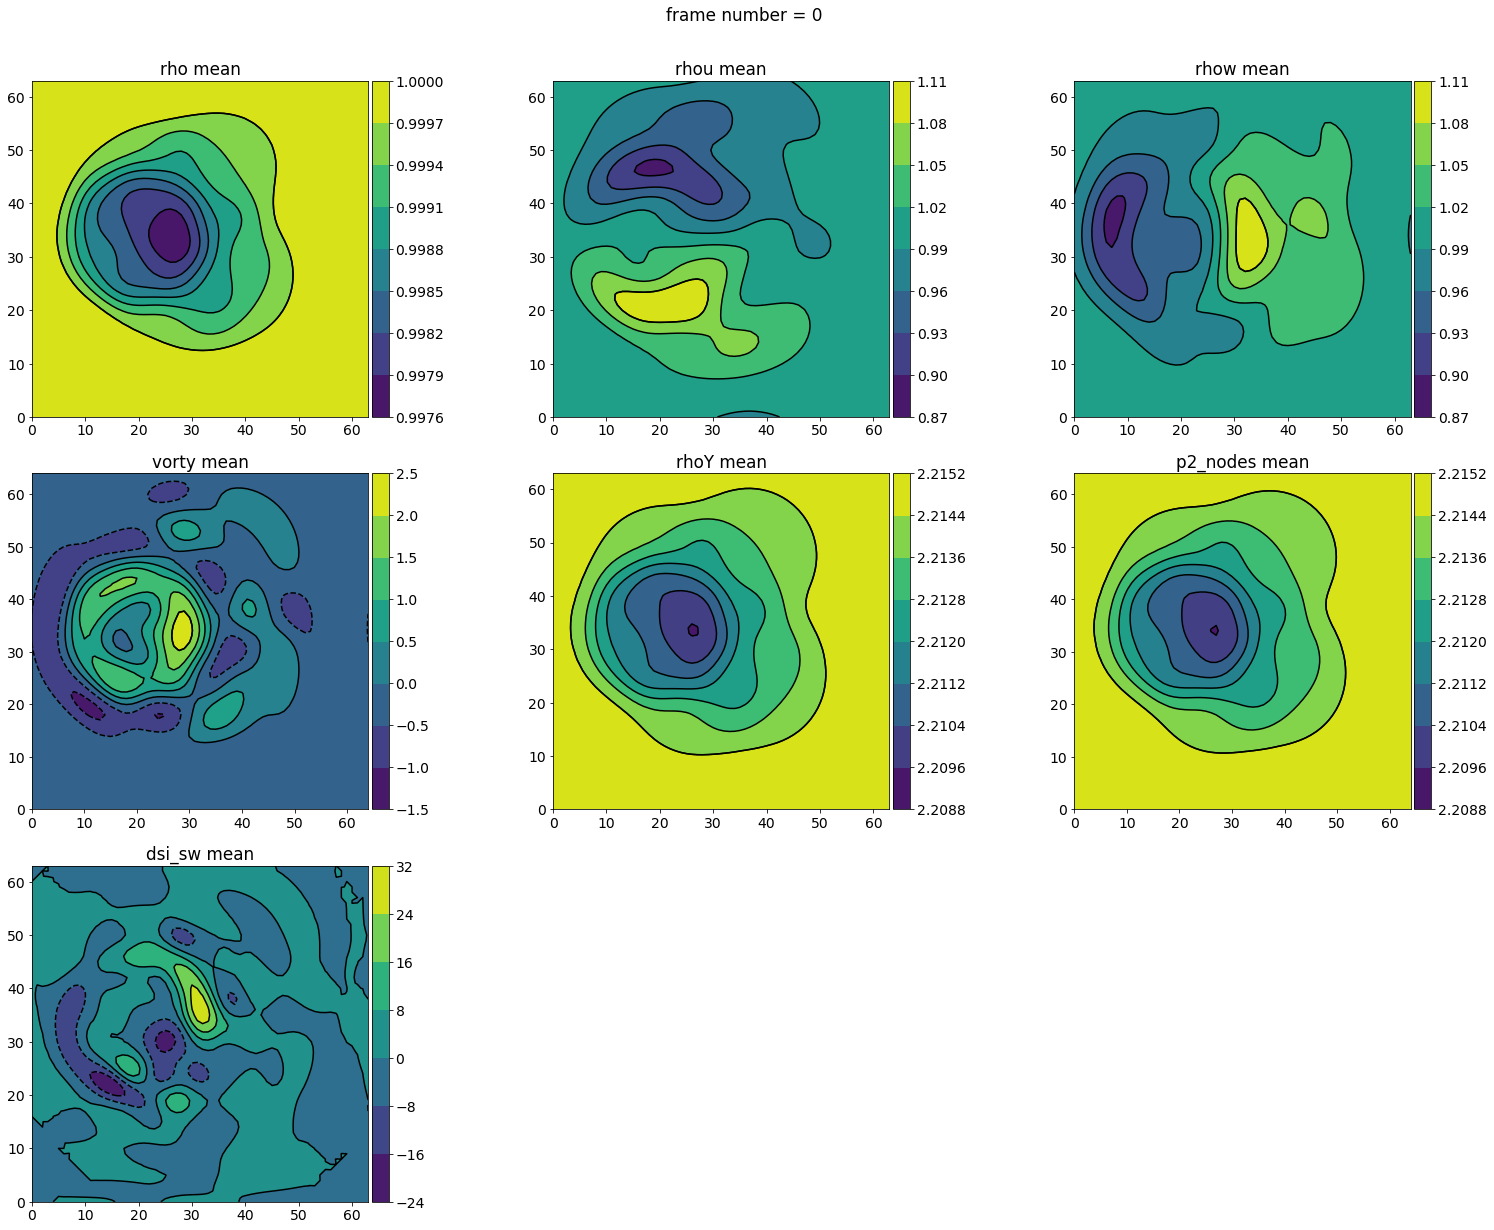

In [274]:
import plotting_tools as pt
pt = reload(pt)

def title_gen(frn):
    return "frame number = %i" %frn

fs = (22,18)
a2d = pt.animator_2D(mean_arrs,ncols=3,figsize=fs)
a2d.suptitle = title_gen
a2d.method = 'contour'
anim = a2d.animate(interval=350, aspect='equal', method='contour')

## Save animation

In [275]:
import matplotlib.animation as animation

Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Ray Chew'), bitrate=6000)
anim.save('bal_vortex_ens_mean_da_test_0.5.mp4', writer=writer)

In [226]:
vec = [1,2,3]
print(vec)

# x, y = 5, 5

vec = np.expand_dims(vec, axis=-1)
vec = np.repeat(vec, x, axis=-1)

vec = np.expand_dims(vec, axis=-1)
vec = np.repeat(vec, y, axis=-1)

print(vec.shape)
print(vec)


# grid = np.ones((len(vec),x,y))
# print(grid)

# # grid = np.expand_dims(grid,axis=0)
# print(grid.shape)
# vec = np.expand_dims(vec,axis=-1)
# # vecgrid = np.tensordot(vec, grid, axis=0)
# vecgrid = vec * grid
# print(vecgrid.shape)

[1, 2, 3]
(3, 5, 5)
[[[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]

 [[2 2 2 2 2]
  [2 2 2 2 2]
  [2 2 2 2 2]
  [2 2 2 2 2]
  [2 2 2 2 2]]

 [[3 3 3 3 3]
  [3 3 3 3 3]
  [3 3 3 3 3]
  [3 3 3 3 3]
  [3 3 3 3 3]]]
